In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as k
#from sklearnex import patch_sklearn
#patch_sklearn()
import sklearn
import os
import numba
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

# Chapter 1

In [3]:
project_folder=str("D:\\Work_folders\\datasets\\NLP-Project2\\Data - Sarcasm Detection")

In [4]:
df=pd.read_json(project_folder+"\\"+"Sarcasm_Headlines_Dataset.json",lines=True)

df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df["is_sarcastic"].to_csv("y_train")

In [5]:
df["length"]=df["headline"].str.len()
    

In [6]:
df.head()

,article_link,headline,is_sarcastic,length
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,78
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,84
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,79
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,84
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,64


Looks like the data here is listed in three columns and the sarcastic or not decision is quoted in binary - this needs to be checked. 

Before that we will add a new column that will see how many characters are there in each headline. Also we have to notice that article_link is given here. But, we can go to that article and extract entire text corpus and check out if works out or not.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
 3   length        26709 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 834.8+ KB


In [8]:
df.isna().any()

article_link    False
headline        False
is_sarcastic    False
length          False
dtype: bool

In [9]:
df["length"].describe()

count    26709.000000
mean        60.910592
std         19.184470
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: length, dtype: float64

<AxesSubplot:xlabel='length'>

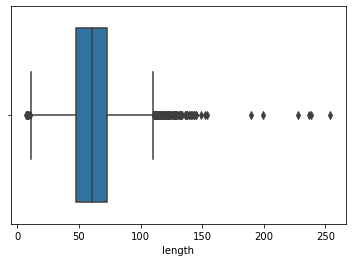

In [10]:
sns.boxplot(df["length"])

<AxesSubplot:xlabel='length', ylabel='Density'>

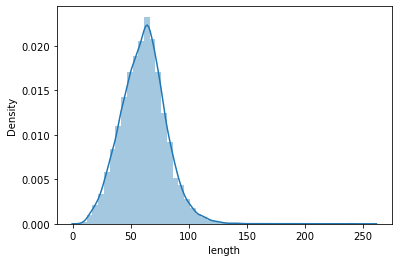

In [11]:
sns.distplot(df["length"])

We can't simply correlate the length of the title with that of the sarcastic nature of it or not. I am not subject expert, but I am not considering it as a possibility.

We can't eliminate something just because the title is too little. It does depend on context, especially the content of the article will, probably, decide whether the title qualifies to be sarcastic. But, for a machine to be something like that, it pushes the project into some real flux here. It is just a heading, it is supposed to be small for any news paper. On the other hand, we have to be suspect of extra long headlines. It needs some examinations. That means, we have to perhaps chop-off the extra length that we are going to have in our text corpus on the Quartile3. Either abandon those entries altogether, which I think is good idea given how big the corpus is. But we can simply restrict the amount of text that is allowed in that columns and chop off something towards the end or the front. We will do further analysis and see what we can do.

In [12]:
check_index=df["length"].sort_values().index
check_index

Int64Index([20551,  9973, 11354, 12208, 22596, 14224, 19767,  6919,  8641,
             4988,
            ...
            21262, 24798, 15944, 23473,  7837, 11220, 21783, 15247, 17306,
            19868],
           dtype='int64', length=26709)

In [13]:
df["headline"].loc[check_index[:-3]]

20551                                              bye bye
9973                                              top cute
11354                                             déjà vu?
12208                                             dip good
22596                                             ant born
                               ...                        
15944    with big names like the cure and grimes shinin...
23473    something to vote for on november 8, 2016:    ...
7837     roy moore on pedophilia accusers: 'these women...
11220    mia farrow: 'it's possible my son was fathered...
21783    occasionally you realize someone you thought w...
Name: headline, Length: 26706, dtype: object

Let us check the last three samples from the data set and see what they are about and do they convey some kind of sarcasm or not.

In [14]:
print("length of the Headline",len(df["headline"].loc[check_index[-1]]))
df["headline"].loc[check_index[-1]]


length of the Headline 254


'maya angelou, poet, author, civil rights activist, and—holy cow—tony award–nominated actress, college professor, magazine editor, streetcar conductor—really? streetcar conductor? wow—calypso singer, nightclub performer, and foreign journalist, dead at 86'

In [15]:
print("length of the Headline",len(df["headline"].loc[check_index[-3]]))
df["headline"].loc[check_index[-3]]


length of the Headline 237


'elmore leonard, modern prose master, noted for his terse prose style and for writing about things perfectly and succinctly with a remarkable economy of words, unfortunately and sadly expired this gloomy tuesday at the age of 87 years old'

In [16]:
print("length of the Headline",len(df["headline"].loc[check_index[-6]]))
df["headline"].loc[check_index[-6]]


length of the Headline 190


"roy moore on pedophilia accusers: 'these women are only discrediting me now because shifting sociocultural norms have created an environment in which assault allegations are taken seriously'"

In [17]:
print("length of the Headline",len(df["headline"].loc[check_index[-10]]))
df["headline"].loc[check_index[-10]]


length of the Headline 145


'multi-institutional collaborative clinical trial to examine health benefits of integrative lifestyle practices at the chopra center for wellbeing'

This doesn't make sense. It doesn't look like it is from one particular article at all. Let us check three more samples before we take a decision on what to do with these things.

In [18]:
df["headline"].values

array(["former versace store clerk sues over secret 'black code' for minority shoppers",
       "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
       "mom starting to fear son's web series closest thing she will have to grandchild",
       ..., 'reparations and obama',
       'israeli ban targeting boycott supporters raises alarm abroad',
       'gourmet gifts for the foodie 2014'], dtype=object)

Let us log into one of those and try to get the pure text format of it.

https://www.kite.com/python/answers/how-to-extract-text-from-an-html-file-in-python

The above is where I got my html text extractor code from. Please give credit where it is due.

In [19]:
##############################################################
# Function used to import data from the given link
##############################################################

def html_link_extractor(url_given):
    from urllib.request import urlopen
    from bs4 import BeautifulSoup
    url=url_given
    #print(url)
    html_link=urlopen(url).read()
    soup=BeautifulSoup(html_link)
    for script in soup(["script","style"]):
        script.decompose()
    strips=list(soup.stripped_strings)
    #print(strips)
    return strips
    
##############################################################
# End of Function
##############################################################

In [20]:
print(df["article_link"].loc[check_index[-1]])
html_link_extractor(df["article_link"].loc[check_index[-1]])

https://www.theonion.com/maya-angelou-poet-author-civil-rights-activist-and-1819591737


['Maya Angelou, Poet, Author, Civil Rights Activist, And—Holy Cow—Tony Award–Nominated Actress, College Professor, Magazine Editor, Streetcar Conductor—Really? Streetcar Conductor? Wow—Calypso Singer, Nightclub Performer, And Foreign Journalist, Dead At 86',
 'The Onion',
 'The A.V. Club',
 'Deadspin',
 'Gizmodo',
 'Jalopnik',
 'Jezebel',
 'Kotaku',
 'Lifehacker',
 'The Root',
 'The Takeout',
 'The Inventory',
 "America's Finest News Source.",
 'Shop',
 'Subscribe',
 'Home',
 'Latest',
 'News',
 'Local',
 'Entertainment',
 'Politics',
 'Sports',
 'Opinion',
 'OGN',
 "America's Finest News Source.",
 'Home',
 'Latest',
 'News',
 'Local',
 'Entertainment',
 'Politics',
 'Sports',
 'Opinion',
 'OGN',
 'News In Photos',
 'Maya Angelou, Poet, Author, Civil Rights Activist, And—Holy Cow—Tony Award–Nominated Actress, College Professor, Magazine Editor, Streetcar Conductor—Really? Streetcar Conductor? Wow—Calypso Singer, Nightclub Performer, And Foreign Journalist, Dead At 86',
 '5/28/14 12:10

In [21]:
print(df["article_link"].loc[check_index[-3]])
html_link_extractor(df["article_link"].loc[check_index[-3]])

https://www.theonion.com/elmore-leonard-modern-prose-master-noted-for-his-ters-1819575450


['Elmore Leonard, Modern Prose Master, Noted For His Terse Prose Style And For Writing About Things Perfectly And Succinctly With A Remarkable Economy Of Words, Unfortunately And Sadly Expired This Gloomy Tuesday At The Age Of 87 Years Old',
 'The Onion',
 'The A.V. Club',
 'Deadspin',
 'Gizmodo',
 'Jalopnik',
 'Jezebel',
 'Kotaku',
 'Lifehacker',
 'The Root',
 'The Takeout',
 'The Inventory',
 "America's Finest News Source.",
 'Shop',
 'Subscribe',
 'Home',
 'Latest',
 'News',
 'Local',
 'Entertainment',
 'Politics',
 'Sports',
 'Opinion',
 'OGN',
 "America's Finest News Source.",
 'Home',
 'Latest',
 'News',
 'Local',
 'Entertainment',
 'Politics',
 'Sports',
 'Opinion',
 'OGN',
 'News In Brief',
 'Elmore Leonard, Modern Prose Master, Noted For His Terse Prose Style And For Writing About Things Perfectly And Succinctly With A Remarkable Economy Of Words, Unfortunately And Sadly Expired This Gloomy Tuesday At The Age Of 87 Years Old',
 '8/20/13 2:21PM',
 'PROLOGUE',
 'It was 10 a.m. w

In [22]:
print(df["article_link"].loc[check_index[-6]])
html_link_extractor(df["article_link"].loc[check_index[-6]])

https://politics.theonion.com/roy-moore-on-pedophilia-accusers-these-women-are-only-1820405898


['Roy Moore On Pedophilia Accusers: ‘These Women Are Only Discrediting Me Now Because Shifting Sociocultural Norms Have Created An Environment In Which Assault Allegations Are Taken Seriously’',
 'The Onion',
 'The A.V. Club',
 'Deadspin',
 'Gizmodo',
 'Jalopnik',
 'Jezebel',
 'Kotaku',
 'Lifehacker',
 'The Root',
 'The Takeout',
 'The Inventory',
 "America's Finest News Source.",
 'Shop',
 'Subscribe',
 'Home',
 'Latest',
 'News',
 'Local',
 'Entertainment',
 'Politics',
 'Sports',
 'Opinion',
 'OGN',
 "America's Finest News Source.",
 'Home',
 'Latest',
 'News',
 'Local',
 'Entertainment',
 'Politics',
 'Sports',
 'Opinion',
 'OGN',
 'Politics',
 'Roy Moore On Pedophilia Accusers: ‘These Women Are Only Discrediting Me Now Because Shifting Sociocultural Norms Have Created An Environment In Which Assault Allegations Are Taken Seriously’',
 '11/13/17 2:23PM',
 'MONTGOMERY, AL—Waving off the current allegations against him as vicious attempts to sabotage his election bid, Alabama Senate 

In [23]:
print(df["article_link"].loc[check_index[1]])
html_link_extractor(df["article_link"].loc[check_index[1]])

https://www.theonion.com/top-cute-1819586814


['Top Cute',
 'The Onion',
 'The A.V. Club',
 'Deadspin',
 'Gizmodo',
 'Jalopnik',
 'Jezebel',
 'Kotaku',
 'Lifehacker',
 'The Root',
 'The Takeout',
 'The Inventory',
 "America's Finest News Source.",
 'Shop',
 'Subscribe',
 'Home',
 'Latest',
 'News',
 'Local',
 'Entertainment',
 'Politics',
 'Sports',
 'Opinion',
 'OGN',
 "America's Finest News Source.",
 'Home',
 'Latest',
 'News',
 'Local',
 'Entertainment',
 'Politics',
 'Sports',
 'Opinion',
 'OGN',
 'News In Photos',
 'Top Cute',
 '5/17/00 3:00PM',
 'Breaking News',
 'News In Photos']

In [24]:
#print(df["article_link"].loc[check_index[2]])
#html_link_extractor(df["article_link"].loc[check_index[2]])

**Note** :
After examining a few sample contents, it looks incredibly tempting to import a lot of these text and simply append them to our dataframe or atleast dump into a temporary file. I have made a few attempts, which I append at the end of the entire section. It was too many articles and links. It looks more like webscraping. So, I let it rest and work with just the headlines. That means, we are obviously going to misrepresent or not going to properly keep our classification properly. It is going to be riddled with errors. As stated, I consider that outside of the scope of problem statement.

**Proposed Plan**
1. Take the corpus of Texts, do some data cleaning with respect to it, and convert them to tokens.
2. Then we will measure the no of words in each text column, considering each entry in the "title" column to be a document in itself and the entire column to consisting of a corpus.
3. Then we will create a set of words and try to check if every word in the vocabulary we have created is actually inside the dictionary of Glove word vectors given to us along with the problem sets.
4. If it doesn't, it necessitates for us to re-construct entire word vector again. It will become extremely difficult. But we will do it by retraining our Glove vector embedding by retraining the Glove. Depending upon the word length and probabilities, we will decide how many dimensions are going to be useful. Of course, we have to eliminate stop words or something, but we will see how we it goes.
5. If we do have it such that our vocabulary of the words is not in the original corpus we will generate the embedding layers with the text, as given clearly in the Keras documentations as given below.

https://keras.io/examples/nlp/pretrained_word_embeddings/

6. We will design layers such that we will include a Bidirectional LSTM along with the embeddings done and will check out for any further modifications. (Finish the objectives later on)


In [25]:
##############################################################
# Function used to prepare file objects for handling and flexibility
##############################################################
def loading_preparation(project_folder):
    file_objects=[]
    for each in os.listdir(project_folder):
        if ".txt" in each:
            print("Imported Files :",each)
            path=os.fspath(project_folder)+"\\"+each
            #file_objects.append(open(path))
            file_objects.append(path)
    return file_objects
##############################################################
# End of Function
##############################################################

##############################################################
# Function used to prepare dataframes from the text corpus we have
##############################################################
@numba.jit
def prepare_df(file_path):
    data=pd.read_table(file_path,header=None,sep="\n\r",lineterminator="\n")[0]
    data=data.apply(str.split)
    tf={}
    for item in data:
        tf.update({item[0] : item[1:]})
        #print(item)
    return pd.DataFrame(tf).T

##############################################################
# End of Function
##############################################################

In [26]:
data=prepare_df(loading_preparation(project_folder)[0])

Imported Files : glove.6B.100d.txt
Imported Files : glove.6B.200d.txt
Imported Files : glove.6B.300d.txt
Imported Files : glove.6B.50d.txt


In [27]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
the,-0.038194,-0.24487,0.72812,-0.39961,0.083172,0.043953,-0.39141,0.3344,-0.57545,0.087459,...,0.016215,-0.017099,-0.38984,0.87424,-0.72569,-0.51058,-0.52028,-0.1459,0.8278,0.27062
",",-0.10767,0.11053,0.59812,-0.54361,0.67396,0.10663,0.038867,0.35481,0.06351,-0.094189,...,0.34951,-0.7226,0.37549,0.4441,-0.99059,0.61214,-0.35111,-0.83155,0.45293,0.082577
.,-0.33979,0.20941,0.46348,-0.64792,-0.38377,0.038034,0.17127,0.15978,0.46619,-0.019169,...,-0.063351,-0.67412,-0.068895,0.53604,-0.87773,0.31802,-0.39242,-0.23394,0.47298,-0.028803
of,-0.1529,-0.24279,0.89837,0.16996,0.53516,0.48784,-0.58826,-0.17982,-1.3581,0.42541,...,0.18712,-0.018488,-0.26757,0.727,-0.59363,-0.34839,-0.56094,-0.591,1.0039,0.20664
to,-0.1897,0.050024,0.19084,-0.049184,-0.089737,0.21006,-0.54952,0.098377,-0.20135,0.34241,...,-0.13134,0.058617,-0.31869,-0.61419,-0.62393,-0.41548,-0.038175,-0.39804,0.47647,-0.15983


The above is the dataframe in which the embedd vectors for each word is given. This is just for reference and understanding. We have to check the corpus of the given text vectors and simply reduce the probable dimensions of the above Embedd Vector dimensions to keep it better and computationally less expensive.


In [28]:
vocabulary={}
for each in loading_preparation(project_folder):
    vocabulary.update({each : list(prepare_df(each).index)})

Imported Files : glove.6B.100d.txt
Imported Files : glove.6B.200d.txt
Imported Files : glove.6B.300d.txt
Imported Files : glove.6B.50d.txt


In [29]:
#Backing up the data just to make sure that we don't completely loose it.
import json
with open('vocabulary_data.json', 'w') as file:
    json.dump(vocabulary, file)
    file.close()

In [30]:
import json
file3=open('vocabulary_data.json',"r")
vocabulary=json.load(file3)

In [31]:
print(vocabulary.keys())
d_100=list(vocabulary.keys())[0]
d_200=list(vocabulary.keys())[1]
d_300=list(vocabulary.keys())[2]
d_50=list(vocabulary.keys())[3]


dict_keys(['D:\\Work_folders\\datasets\\NLP-Project2\\Data - Sarcasm Detection\\glove.6B.100d.txt', 'D:\\Work_folders\\datasets\\NLP-Project2\\Data - Sarcasm Detection\\glove.6B.200d.txt', 'D:\\Work_folders\\datasets\\NLP-Project2\\Data - Sarcasm Detection\\glove.6B.300d.txt', 'D:\\Work_folders\\datasets\\NLP-Project2\\Data - Sarcasm Detection\\glove.6B.50d.txt'])


In [32]:
print("The total number of documents is :",len(df.index))

The total number of documents is : 26709


Now let us check how many number of words are there and how many will come in each iteration. For our current analysis we will stick to the 100 dimensional embedding and design a function where we can choose which one we will want to use depending upon how many words we are going to gather and how we are going to distribute them across the vector dimensions. We will take decision based on that. 

**Note**
Though other higher level calls are available directly for this, we will manually do all this to get a good sense of what is going on in the background.


In [33]:
#d=pd.DataFrame(np.loadtxt(inp,dtype=None,delimiter=" "))

So, here the same Vocabulary is coded in both 50 dimensional vector, a 100 dimensional vector and also 200 and 300 dimensional Vector.

In [34]:
import nltk 
from nltk.probability import FreqDist
nltk.FreqDist(df["headline"])

FreqDist({'sunday roundup': 10, 'the 20 funniest tweets from women this week': 10, "'no way to prevent this,' says only nation where this regularly happens": 8, 'the funniest tweets from parents this week': 6, 'the funniest tweets from women this week': 4, 'sole remaining lung filled with rich, satisfying flavor': 3, 'magic-markered initials fail to deter breakroom rice-cake thief': 2, 'antarctic observational comic running out of ideas': 2, 'the best chance to defeat roy moore may be for the democratic party to lie low': 2, 'pier 1 issues formal apology for rattan death march': 2, ...})

In [35]:
def freq_distribution(Series_given):
    words_text=[item for sublist in list(Series_given) for item in sublist]
    return dict(FreqDist(words_text))
    

In [36]:

from nltk.tokenize import word_tokenize

df["headline"]=df["headline"].apply(word_tokenize)
df["word_no"]=df["headline"].apply(len) # Word NO count for keeping track
temp=list(df["headline"])

In [37]:
headline_corp=freq_distribution(df["headline"])

Let us have a brief look at the number of words that are present in each headline, by maximum and minimum.

We will have a brief discussion about this topic of how many words to keep much later on.

In [38]:
test1=set(headline_corp.keys())

Now we have the corpus of words that is in headlines and now let us check what is the difference between the words that are given in the headlines corpus and the word vector that we have imported from glove.

In [39]:
count=len(test1)

In [40]:
#First let us check with the data with the vocabulary with 100_d vectors.
#data=json.loads("vocabulary_data.json")
test2=set(vocabulary[d_100])
print("The total Number of unique words in the Corpus of Glove Embedding 100d are : ",len(test2))
test3=set(vocabulary[d_200])
print("The total Number of unique words in the Corpus of Glove Embedding 200d are : ",len(test3))
test4=set(vocabulary[d_300])
print("The total Number of unique words in the Corpus of Glove Embedding 300d are : ",len(test4))
test5=set(vocabulary[d_50])
print("The total Number of unique words in the Corpus of Glove Embedding 50d are : ",len(test5))
print(len(test2-test3),len(test3-test4),len(test4-test5))
#This shows the words that are present in our 100 Dimensional Glove Vector and 
# and the corpus of text we have here.
if len(test2.intersection(test3))!=0:
    print("All the word dimensions represent same set of words\n")
print("Total Number of Unique words in Headline Corpus is :",len(test1))
print("This number of words that are in corpus and not in 100 Dimensional Vector is :",len(test1-test2))

The total Number of unique words in the Corpus of Glove Embedding 100d are :  400000
The total Number of unique words in the Corpus of Glove Embedding 200d are :  400000
The total Number of unique words in the Corpus of Glove Embedding 300d are :  400000
The total Number of unique words in the Corpus of Glove Embedding 50d are :  400000
0 0 0
All the word dimensions represent same set of words

Total Number of Unique words in Headline Corpus is : 29280
This number of words that are in corpus and not in 100 Dimensional Vector is : 4231


It is confirmed here that there are a total of 29280 words in Headlines corpus. Some of which are present inside the Glove vector and some aren't. So, let's do the same analysis of it after removing stop words and see if the same number of words still remain. If there are some words that still remain, we will check the frequencies of those words and decide what we will do with them.

Before we proceed, since we have already established here, we are free to deal with 100_d data and we will now be dealing with only that.

In [41]:
import nltk
nltk.download('stopwords')
from string import punctuation
from nltk.corpus import stopwords 
stop_words = stopwords.words('english') + list(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sheshank_Joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Before We proceed please note here**
Glove Vector Embeddings, obviously, has few of a the punctuations too i.e. it has not been lemmatized. We leave it as it is since it is done on a much greater purpose and I am not sure what is going to happen if we eliminate vectors from vector space i.e. will they affect the integrity of the vector space or not, since clusters possibly loose their strength.

In [42]:
print("The Total number of words that are not unique in the original corpus are : ",len(test1-test2)-count)

The Total number of words that are not unique in the original corpus are :  -25049


Now, let us do lemmatization and check if it changes or not, then we will proceed further.

In [43]:
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
lemmatized_corps=[lemmatizer.lemmatize(word) for word in test1 if word not in stop_words and not word.isdigit()]

Checking more for the intersection

In [44]:
test6=set(lemmatized_corps)

This is the most important set, which will decide which things wer are going to drop in future while progressing.

In [45]:
#small testing
for each in test6:
    if each in stop_words:
        print(each)

don
can
as
being
t
m
down
out


In [46]:
print("The Total number of words that are not unique in the original corpus are : ",len(test6-test2)-count)

The Total number of words that are not unique in the original corpus are :  -25075


So, the difference is not much. So, there are some unique words within the text corpus given to us that are not present in the glove embedding vectors. Hence, we will supply them to our embedding layers. They might actually be the key indicators as to whether something falls into the category of sarcasm or not. We can go into a considerable detail and analysis of those words, what percentage and probability does those words carry with that decide whether the contribute anything towards the decision of sarcasm or not (i.e. if they are equally distributed in both the classes of the data or not). But that's too much of an analysis not required of the problem set. So, we are moving ahead.


**Further Approach**
I am planning to go an a little advanced approach towards this and let things automate, instead of going for machine learning or nltk. I am going direclty to Keras and do as is listed very easily on the examples, as mentioned already, in the documentation itself.

A Little code addressing one of the problems asked for in the problem statement i.e. vocablary. Though already created, I am going to do it here once again.

In [47]:
##############################################################
# Function used to convert each list of tokenized words into lemmatized words
##############################################################
def word_lemma(sequence):
    from nltk.stem import WordNetLemmatizer
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in sequence if word not in stop_words and not word.isdigit()]
##############################################################
# End of Function
##############################################################

In [48]:
df["headline"][1]

['the',
 "'roseanne",
 "'",
 'revival',
 'catches',
 'up',
 'to',
 'our',
 'thorny',
 'political',
 'mood',
 ',',
 'for',
 'better',
 'and',
 'worse']

In [49]:
df["headline"].apply(word_lemma)[1]

["'roseanne",
 'revival',
 'catch',
 'thorny',
 'political',
 'mood',
 'better',
 'worse']

We can see the significant difference here in the number of non-obvious and frequent words that might actually contribute to the sarcastic tone of the headlines. But, let us wait and see how this pans out.

In [50]:
df["headline"]=df["headline"].apply(word_lemma)
df["len_2"]=df["headline"].apply(len)

In [51]:
df.head()

,article_link,headline,is_sarcastic,length,word_no,len_2
0,https://www.huffingtonpost.com/entry/versace-b...,"[former, versace, store, clerk, sue, secret, '...",0,78,13,10
1,https://www.huffingtonpost.com/entry/roseanne-...,"['roseanne, revival, catch, thorny, political,...",0,84,16,8
2,https://local.theonion.com/mom-starting-to-fea...,"[mom, starting, fear, son, 's, web, series, cl...",1,79,15,10
3,https://politics.theonion.com/boehner-just-wan...,"[boehner, want, wife, listen, come, alternativ...",1,84,14,8
4,https://www.huffingtonpost.com/entry/jk-rowlin...,"[j.k., rowling, wish, snape, happy, birthday, ...",0,64,11,8


In [52]:
df["len_2"].describe()

count    26709.000000
mean         7.217530
std          2.377083
min          0.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         27.000000
Name: len_2, dtype: float64

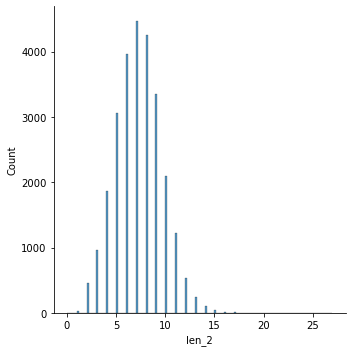

In [53]:
sns.displot(df["len_2"]) # A quick check on how the number of words is distributed.

Since there are very few words in the whole of the headlines, it is only negatively rewarding to do anything to it like POS tagging or something similar. So, lets leave it there and have a brief look at the entries where there are no words after lemmatization, indicating that most probably they were filled with stop words. That means they don't obviously carry that much of a meaning, or that they may be in conjunction with the original text of the article. It is beyond the scope of the problem statement. Hence, it is not being considered here. So, only a brief look at the count of them.

In [54]:
df[df["len_2"]==0]

,article_link,headline,is_sarcastic,length,word_no,len_2
5322,https://www.huffingtonpost.com/entry/i-was-but...,[],0,19,7,0


Thankfully, there is only one headline where the headlines are filled with stop words. 

**Some Observations and Notices**

Once again, I reiterate the third time that it is completely contextual of the Current prevailing situation that will decide whether a word will contribute towards generating sarcasm or not. Sometimes, even the entire corpus of the original article might not be able to sufficient to explain whether what we have observed a certain pattern. As far as my knowledge goes, it all depends on the day it is published, and the current prevailing sitautions of the time along with immediate events that were leading upto it or may follow it.

Let us now prepare a complete word vocabulary with index and initialized word vectors and properly place it.

In [55]:
data.index.name="word"

In [56]:
data_2=data.reset_index()

In [57]:
vocab_final=dict(data_2["word"]) #To this series we will try to append our missing words based on frequency distribution
vocab_final

{0: 'the',
 1: ',',
 2: '.',
 3: 'of',
 4: 'to',
 5: 'and',
 6: 'in',
 7: 'a',
 8: '"',
 9: "'s",
 10: 'for',
 11: '-',
 12: 'that',
 13: 'on',
 14: 'is',
 15: 'was',
 16: 'said',
 17: 'with',
 18: 'he',
 19: 'as',
 20: 'it',
 21: 'by',
 22: 'at',
 23: '(',
 24: ')',
 25: 'from',
 26: 'his',
 27: "''",
 28: '``',
 29: 'an',
 30: 'be',
 31: 'has',
 32: 'are',
 33: 'have',
 34: 'but',
 35: 'were',
 36: 'not',
 37: 'this',
 38: 'who',
 39: 'they',
 40: 'had',
 41: 'i',
 42: 'which',
 43: 'will',
 44: 'their',
 45: ':',
 46: 'or',
 47: 'its',
 48: 'one',
 49: 'after',
 50: 'new',
 51: 'been',
 52: 'also',
 53: 'we',
 54: 'would',
 55: 'two',
 56: 'more',
 57: "'",
 58: 'first',
 59: 'about',
 60: 'up',
 61: 'when',
 62: 'year',
 63: 'there',
 64: 'all',
 65: '--',
 66: 'out',
 67: 'she',
 68: 'other',
 69: 'people',
 70: "n't",
 71: 'her',
 72: 'percent',
 73: 'than',
 74: 'over',
 75: 'into',
 76: 'last',
 77: 'some',
 78: 'government',
 79: 'time',
 80: '$',
 81: 'you',
 82: 'years',
 83

We have to recreate our frequency distribution, since we have already lemmatized the words and eliminated a lot of words.

In [58]:
headline_corp=pd.Series(freq_distribution(df["headline"]))

In [59]:
headline_corp.loc[test6-test2].sort_values(ascending=False)

'the            202
'we              36
'snl             36
'you             36
'it              35
               ... 
'kill             1
salt-assault      1
smug-bastard      1
'fearful          1
'wipe             1
Length: 4205, dtype: int64

Looks like there are some unusual number of words out htere, especially with punctuation and all. I have checked it- but not included here - that these some words escaped our lemmatization process and stop words. That usually because they accompanied quotes. Quotes are the most important and genuine way to actually figure out sarcasm in any kind of sentence. So, I am going to retain them and use it for my model ahead and add it for vocabulary. We can do further research into how we can differentiate these words, and how we can eliminate worthy individuals for sarcasm against the fooling ones. But, I am not going to go there.

In [60]:
irrelevant_words=test2-test6
print("Total Number of words that are present in the import but in our corpus is : ",len(irrelevant_words))

Total Number of words that are present in the import but in our corpus is :  378295


In [61]:
file=open("irrelevant_words.json","w")
json.dump(list(irrelevant_words),file)
file.close()

In [63]:
extra_words=headline_corp.loc[test6-test2].index
file=open("extra_words.json","w")
json.dump(list(extra_words),file)
file.close()

In [64]:
extra_words

Index(['unicyclist', 'network-tv', 'porn-store', ''thank', 'bejewel', '¡que',
       ''1989', 'grease-covered', 'once-homeless', 'cheese-related',
       ...
       ''least', 'love-tester', '.00003', ''build', 'helmet-inspired', 'jlaw',
       ''justice', ''life-changer', ''gobble', ''wipe'],
      dtype='object', length=4205)

In [65]:
len(vocab_final.keys())

400000

In [66]:
vocab_final.update({len(vocab_final)+i-1:word for i,word in enumerate(extra_words)})

In [73]:
chec=set(list(vocab_final.keys()))
chec2=set(range(404204))
print(len(chec-chec2))
print(len(chec2-chec))

0
0


In [74]:
file=open("vocab_final.json","w")
json.dump(vocab_final,file)
file.close()

In [75]:
dict(vocab_final)[224]

'major'

**Please Note**
My Computing Resources were not enough to run through the entire corpus. I have to cut short after hours and hours of processing. So, came up with this idea of only first 1500 data points. 

# End of Chapter 1

In [83]:
df.to_json("data_ready.json")

In [84]:
data.to_json("data_vector.json")

In [81]:
df3=pd.DataFrame(df["headline"].tolist(),index=df.index)

In [82]:
df3

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,former,versace,store,clerk,sue,secret,'black,code,minority,shopper,...,None,None,None,None,None,None,None,None,None,None
1,'roseanne,revival,catch,thorny,political,mood,better,worse,None,None,...,None,None,None,None,None,None,None,None,None,None
2,mom,starting,fear,son,'s,web,series,closest,thing,grandchild,...,None,None,None,None,None,None,None,None,None,None
3,boehner,want,wife,listen,come,alternative,debt-reduction,idea,None,None,...,None,None,None,None,None,None,None,None,None,None
4,j.k.,rowling,wish,snape,happy,birthday,magical,way,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26704,american,politics,moral,free-fall,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
26705,america,'s,best,hike,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
26706,reparation,obama,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
26707,israeli,ban,targeting,boycott,supporter,raise,alarm,abroad,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
#df2["new_headline"]=df2["headline"].apply(word_tokens,vocab_final=vocab_final)

In [ ]:
pd.Series(word_index_rev)

In [ ]:
pd.Series(word_index_rev)

In [ ]:
len(word_index_rev)

In [80]:
word_index_rev

NameError: name 'word_index_rev' is not defined

In [ ]:
l=df3[:10000].replace(to_replace=word_index_rev) #just a check how it is working out
l

In [ ]:
l+=1
l

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

df3=pd.DataFrame(pad_sequences(df3["headline"]))

In [ ]:
df3.to_csv("df3.csv")

If we recall, we can go back and check that we already have a dataframe that is filled with word vectors for all 40000 of our words. So, we can go back and create a new dataframe with the newly created words that is named earlier as extra_words and make into a dataframe that is exactly matching with dimensions of our original dataframe so that our corpus is ready to be trained on pre-embeddings with new words added to the corpus, so that we can better detect sarcasm.

In [76]:
data

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
word,,,,,,,,,,,,,,,,,,,,,
the,-0.038194,-0.24487,0.72812,-0.39961,0.083172,0.043953,-0.39141,0.3344,-0.57545,0.087459,...,0.016215,-0.017099,-0.38984,0.87424,-0.72569,-0.51058,-0.52028,-0.1459,0.8278,0.27062
",",-0.10767,0.11053,0.59812,-0.54361,0.67396,0.10663,0.038867,0.35481,0.06351,-0.094189,...,0.34951,-0.7226,0.37549,0.4441,-0.99059,0.61214,-0.35111,-0.83155,0.45293,0.082577
.,-0.33979,0.20941,0.46348,-0.64792,-0.38377,0.038034,0.17127,0.15978,0.46619,-0.019169,...,-0.063351,-0.67412,-0.068895,0.53604,-0.87773,0.31802,-0.39242,-0.23394,0.47298,-0.028803
of,-0.1529,-0.24279,0.89837,0.16996,0.53516,0.48784,-0.58826,-0.17982,-1.3581,0.42541,...,0.18712,-0.018488,-0.26757,0.727,-0.59363,-0.34839,-0.56094,-0.591,1.0039,0.20664
to,-0.1897,0.050024,0.19084,-0.049184,-0.089737,0.21006,-0.54952,0.098377,-0.20135,0.34241,...,-0.13134,0.058617,-0.31869,-0.61419,-0.62393,-0.41548,-0.038175,-0.39804,0.47647,-0.15983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chanty,-0.15577,-0.049188,-0.064377,0.2236,-0.20146,-0.038963,0.12971,-0.29451,0.0035897,-0.098377,...,0.093324,0.094486,-0.023469,-0.48099,0.62332,0.024318,-0.27587,0.075044,-0.5638,0.14501
kronik,-0.094426,0.14725,-0.15739,0.071966,-0.29845,0.039432,0.02187,0.0080409,-0.18682,-0.31101,...,-0.30545,-0.011082,0.11855,-0.11312,0.33951,-0.22449,0.25743,0.63143,-0.2009,-0.10542
rolonda,0.36088,-0.16919,-0.32704,0.098332,-0.4297,-0.18874,0.45556,0.28529,0.3034,-0.36683,...,-0.044082,0.14003,0.30007,-0.12731,-0.14304,-0.069396,0.2816,0.27139,-0.29188,0.16109


In [77]:
to_append=pd.DataFrame(0,index=extra_words,columns=range(100))
to_append

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
toll-booth,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
emojisinthewild,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'bet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'very,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'share,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nidetch,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
easy-grip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'sweetie,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'bring,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
data=pd.concat([data,to_append]) #This is our final dataframe that we are going to convert to a word_index for pre-training

In [79]:
data_new=data.drop(irrelevant_words,axis=0).copy()

**Note**:
Now we can go ahead and try to eliminate more than half of words that don't occur at all in our given corpus. It is pretty easy and would probably save a lot on our computational complexity. However, I am going to give it a chance, keep it as it is, in the hopes to use it in future sometime, or perhaps adding in more data for other purposes.

But for this specific problem, I am going to drop it.

There are not hits and misses here. There is a room for a LOTS of improvement and optimization here. But due to time complexity involved, it is being ignored here and I am going with it like that here because I am only using a part of the dataframe i.e. just 1500 data points from the given corpus because of the computational complexity involved.

But before that let us save the data lest, we loose it.

In [80]:
data_new.to_json("Final_table.json",index=True)

In [ ]:
df2.to_csv("df2.csv")

In [81]:
data_new=data_new.reset_index().drop(["index"],axis=1).T

## Model Layout

**Note** : I deliberately choose small and simple model for the sake of training and everything. Please be considerate on that.